In [1]:
#!pip install medmnist

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

import medmnist
from medmnist import INFO, Evaluator

import sys
sys.path.insert(0,"../")

import dataset_without_pytorch

from dataset_without_pytorch import get_loader
from functions import split_data, get_label_counts, build_basic_model
from plotting_functions import plot_history

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [4]:
data_flag = 'pneumoniamnist'

download = True

BATCH_SIZE = 128
image_size = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(dataset_without_pytorch, info['python_class'])

In [5]:
# load the data
train_dataset = DataClass(split='train', download=download, size = image_size)
test_dataset = DataClass(split='test', download=download, size = image_size)
val_dataset = DataClass(split='val', download=download, size = image_size)

Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\pneumoniamnist_128.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\pneumoniamnist_128.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\pneumoniamnist_128.npz


In [6]:
print(train_dataset)

Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: C:\Users\Will Poulett\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0


In [7]:
RANDOM_SEED = 1

X_train, y_train, X_val, y_val, X_test_A, y_test_A, X_test_B, y_test_B = split_data(
  train_dataset, test_dataset, val_dataset, RANDOM_SEED = RANDOM_SEED)

In [8]:
get_label_counts(y_train,y_val,y_test_A,y_test_B,class_labels = [0,1],class_names = ["Normal","Pneumonia"])


Train Normal 1214
Train Pneumonia 3494

Val Normal 135
Val Pneumonia 389

Test A Normal 70
Test A Pneumonia 117

Test B Normal 164
Test B Pneumonia 273


In [9]:
# resize data for deep learning 
X_train = np.array(X_train).reshape(-1, image_size, image_size, 1)
y_train = np.array(y_train)

X_val = np.array(X_val).reshape(-1, image_size, image_size, 1)
y_val = np.array(y_val)

X_test_A = np.array(X_test_A).reshape(-1, image_size, image_size, 1)
y_test_A = np.array(y_test_A)

X_test_B = np.array(X_test_B).reshape(-1, image_size, image_size, 1)
y_test_B = np.array(y_test_B)

In [10]:
model = build_basic_model(input_shape = (128,128,1), num_classes = 2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        2

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./simple_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"simple_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [12]:
history = model.fit(X_train,y_train, batch_size = 32, epochs = 30 , validation_data = (X_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

Epoch 1/30
148/148 [==============================] - 68s 454ms/step - loss: 0.4176 - accuracy: 0.8991 - val_loss: 0.1385 - val_accuracy: 0.9427 - lr: 0.0010
Epoch 2/30


c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


148/148 [==============================] - 68s 462ms/step - loss: 0.1455 - accuracy: 0.9535 - val_loss: 0.0915 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 3/30
148/148 [==============================] - 66s 448ms/step - loss: 0.1128 - accuracy: 0.9613 - val_loss: 1.0089 - val_accuracy: 0.6221 - lr: 0.0010
Epoch 4/30
148/148 [==============================] - ETA: 0s - loss: 0.0957 - accuracy: 0.9692
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
148/148 [==============================] - 69s 464ms/step - loss: 0.0957 - accuracy: 0.9692 - val_loss: 0.1825 - val_accuracy: 0.9332 - lr: 0.0010
Epoch 5/30
148/148 [==============================] - 65s 437ms/step - loss: 0.0504 - accuracy: 0.9828 - val_loss: 0.1246 - val_accuracy: 0.9676 - lr: 3.0000e-04
Epoch 6/30
148/148 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9862
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
148/148 [==============================] -

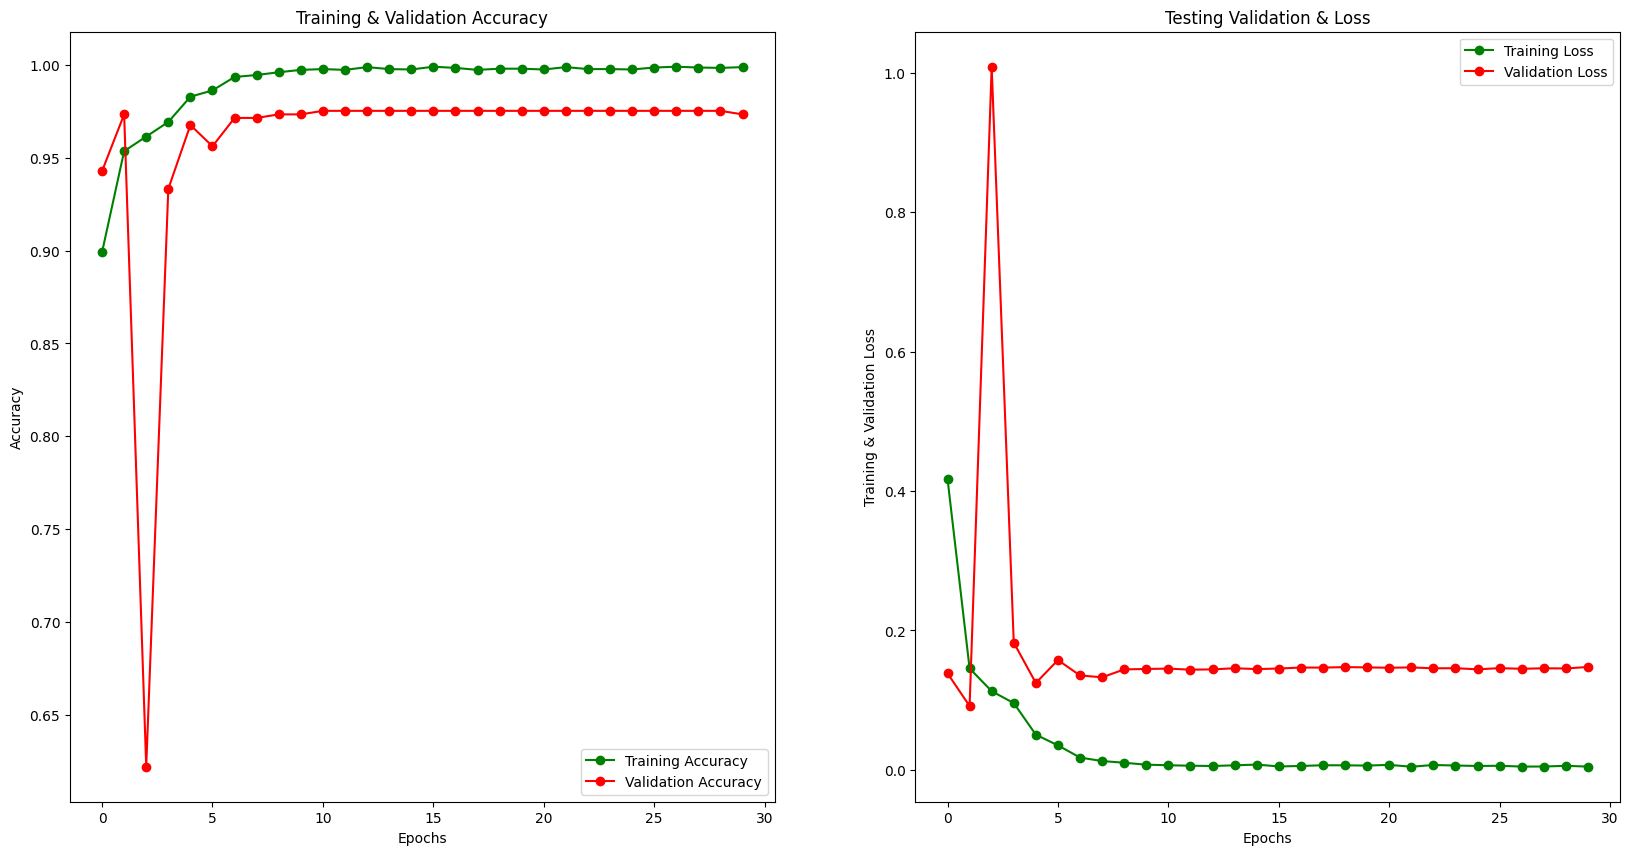

In [13]:
plot_history(history, size=(20,10), epochs = 30)

In [14]:
best_model = keras.models.load_model("./simple_models/best_model_epoch_02.h5")

In [15]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
predictions_A = predictions_A.reshape(1,-1)[0]
predictions_B = predictions_B.reshape(1,-1)[0]

print("Test Set A")
print(classification_report(y_test_A, [round(p,0) for p in predictions_A], target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
print("\nTest Set B")
print(classification_report(y_test_B, [round(p,0) for p in predictions_B], target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

print("Test Set A")
print(confusion_matrix(y_test_A, [round(p,0) for p in predictions_A]))
print("\nTest Set B")
print(confusion_matrix(y_test_B, [round(p,0) for p in predictions_B]))

14/14 [==============================] - 1s 73ms/step
Test Set A
                     precision    recall  f1-score   support

   Normal (Class 0)       0.98      0.59      0.73        70
Pneumonia (Class 1)       0.80      0.99      0.89       117

           accuracy                           0.84       187
          macro avg       0.89      0.79      0.81       187
       weighted avg       0.87      0.84      0.83       187


Test Set B
                     precision    recall  f1-score   support

   Normal (Class 0)       0.95      0.58      0.72       164
Pneumonia (Class 1)       0.80      0.98      0.88       273

           accuracy                           0.83       437
          macro avg       0.87      0.78      0.80       437
       weighted avg       0.85      0.83      0.82       437

Test Set A
[[ 41  29]
 [  1 116]]

Test Set B
[[ 95  69]
 [  5 268]]


In [16]:
model = build_basic_model(input_shape = (128,128,1), num_classes = 2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_5 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_6 (Bat  (None, 64, 64, 64)       

In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./advance_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"./advance_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [19]:
history_2 = model.fit(datagen.flow(X_train,y_train, batch_size = 32), epochs = 30 ,  validation_data = datagen.flow(X_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)


Epoch 1/30
148/148 [==============================] - 55s 367ms/step - loss: 0.5031 - accuracy: 0.8698 - val_loss: 0.2474 - val_accuracy: 0.8855 - lr: 0.0010
Epoch 2/30


c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


148/148 [==============================] - 57s 385ms/step - loss: 0.2299 - accuracy: 0.9225 - val_loss: 0.2280 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 3/30
148/148 [==============================] - 59s 396ms/step - loss: 0.1777 - accuracy: 0.9397 - val_loss: 0.2708 - val_accuracy: 0.9313 - lr: 0.0010
Epoch 4/30
148/148 [==============================] - 57s 383ms/step - loss: 0.1640 - accuracy: 0.9399 - val_loss: 0.1329 - val_accuracy: 0.9485 - lr: 0.0010
Epoch 5/30
148/148 [==============================] - 64s 431ms/step - loss: 0.1407 - accuracy: 0.9511 - val_loss: 0.1335 - val_accuracy: 0.9313 - lr: 0.0010
Epoch 6/30
148/148 [==============================] - ETA: 0s - loss: 0.1449 - accuracy: 0.9492
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
148/148 [==============================] - 54s 365ms/step - loss: 0.1449 - accuracy: 0.9492 - val_loss: 0.3699 - val_accuracy: 0.9027 - lr: 0.0010
Epoch 7/30
148/148 [==============================] - 58s 39

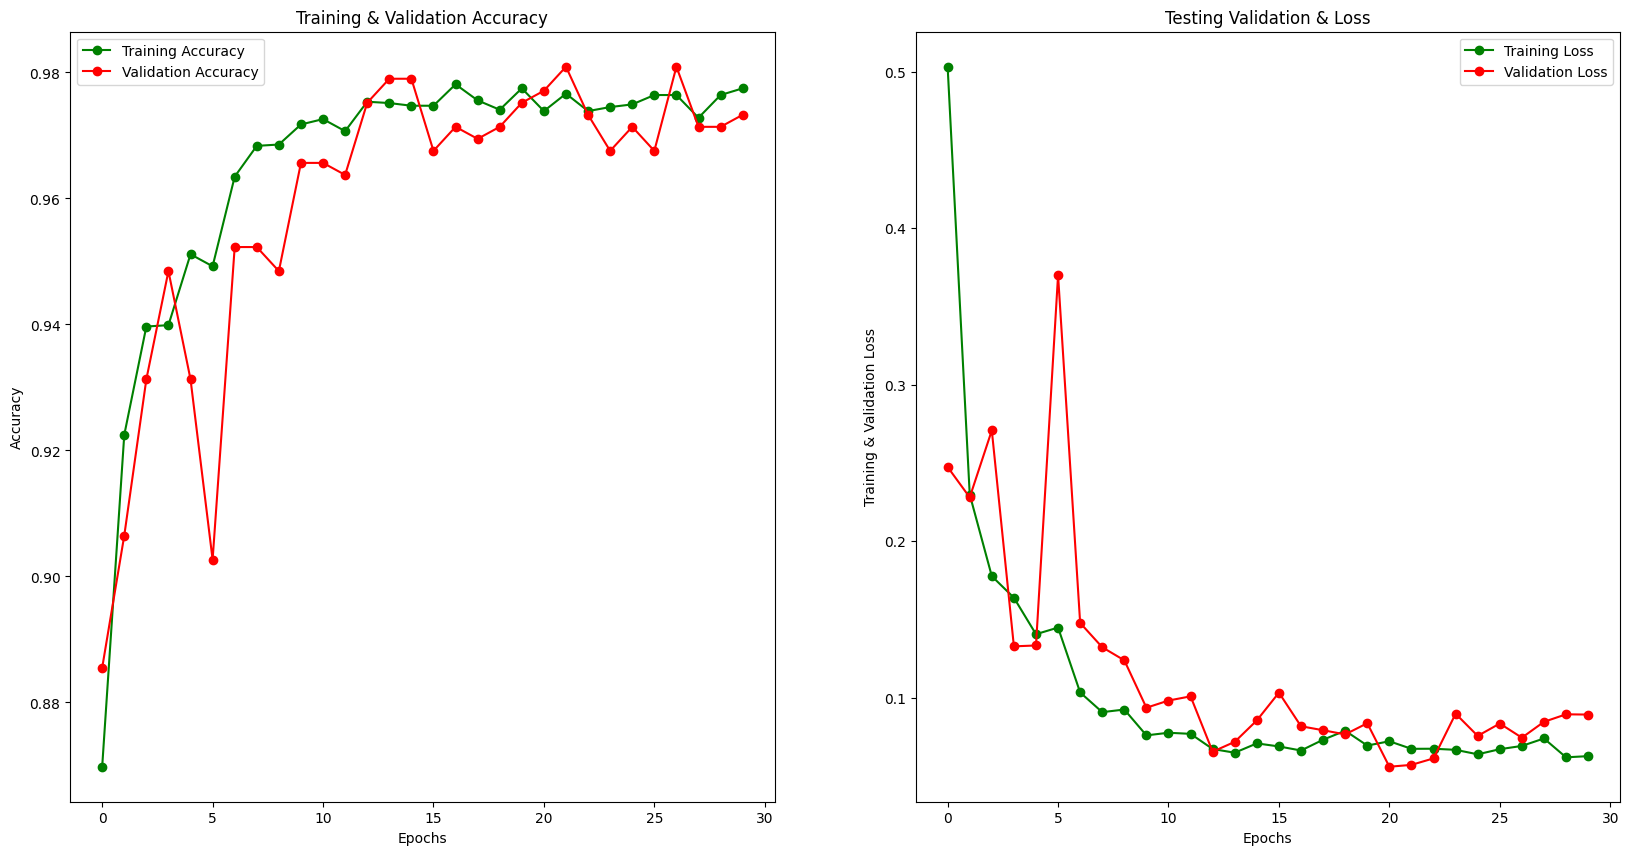

In [20]:
plot_history(history_2, size=(20,10), epochs = 30)

In [21]:
best_model = keras.models.load_model("./advance_models/best_model_epoch_21.h5")

In [22]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
predictions_A = predictions_A.reshape(1,-1)[0]
predictions_B = predictions_B.reshape(1,-1)[0]

print("Test Set A")
print(classification_report(y_test_A, [round(p,0) for p in predictions_A], target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
print("\nTest Set B")
print(classification_report(y_test_B, [round(p,0) for p in predictions_B], target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

print("Test Set A")
print(confusion_matrix(y_test_A, [round(p,0) for p in predictions_A]))
print("\nTest Set B")
print(confusion_matrix(y_test_B, [round(p,0) for p in predictions_B]))

14/14 [==============================] - 1s 70ms/step
Test Set A
                     precision    recall  f1-score   support

   Normal (Class 0)       0.96      0.66      0.78        70
Pneumonia (Class 1)       0.83      0.98      0.90       117

           accuracy                           0.86       187
          macro avg       0.89      0.82      0.84       187
       weighted avg       0.88      0.86      0.85       187


Test Set B
                     precision    recall  f1-score   support

   Normal (Class 0)       0.97      0.70      0.81       164
Pneumonia (Class 1)       0.85      0.99      0.91       273

           accuracy                           0.88       437
          macro avg       0.91      0.84      0.86       437
       weighted avg       0.89      0.88      0.87       437

Test Set A
[[ 46  24]
 [  2 115]]

Test Set B
[[115  49]
 [  4 269]]


In [28]:
print(history.history["accuracy"])
print(history.history["loss"])
print(history.history["val_accuracy"])
print(history.history["val_loss"])

print(history_2.history["accuracy"])
print(history_2.history["loss"])
print(history_2.history["val_accuracy"])
print(history_2.history["val_loss"])

[0.8991078734397888, 0.9534834027290344, 0.9613423943519592, 0.969201385974884, 0.982795238494873, 0.9861937165260315, 0.9934154748916626, 0.9944775104522705, 0.9959642887115479, 0.9972387552261353, 0.9976635575294495, 0.9972387552261353, 0.9987255930900574, 0.9976635575294495, 0.99745112657547, 0.9989379644393921, 0.9983007907867432, 0.9972387552261353, 0.9978759288787842, 0.9978759288787842, 0.99745112657547, 0.9987255930900574, 0.9976635575294495, 0.9976635575294495, 0.99745112657547, 0.9985131621360779, 0.9989379644393921, 0.9985131621360779, 0.9983007907867432, 0.9987255930900574]
[0.4176273047924042, 0.14553359150886536, 0.11282457411289215, 0.09574678540229797, 0.050437524914741516, 0.035075653344392776, 0.017596082761883736, 0.01261324342340231, 0.01013930607587099, 0.00737639470025897, 0.006556419190019369, 0.0058727446012198925, 0.005503029562532902, 0.006434054579585791, 0.007552577182650566, 0.004850446712225676, 0.005516896955668926, 0.0065805441699922085, 0.00644823256880